**STEP 0: Setup Libraries**

In [34]:
# Install required libraries (usually already installed in Colab)
!pip install gradio joblib


**STEP 1: Import Libraries**

In [35]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

# Model saving
import joblib


**STEP 2: Load Dataset**

In [36]:
# Load dataset
df = pd.read_csv("Telco-Customer-Churn.csv")

# Quick look
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**STEP 3: Basic Data Cleaning**

In [37]:
# Drop customer ID (not useful for prediction)
df.drop(columns=["customerID"], inplace=True)

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Handle missing values
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Convert target variable to binary
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


/tmp/ipython-input-1053600552.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


**STEP 4: Split Features & Target**

In [38]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


**STEP 5: Preprocessing Pipeline (MOST IMPORTANT PART)**

**Identify Feature Types**

In [39]:
# Numerical & categorical columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns


**Create ColumnTransformer**

In [40]:
# Numerical pipeline
num_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features)
    ]
)


**STEP 6: Build Full ML Pipelines**

**Logistic Regression Pipeline**

In [41]:
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])


**Random Forest Pipeline**

In [42]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])


**STEP 7: Hyperparameter Tuning (GridSearchCV)**

**Logistic Regression Grid**

In [43]:
logreg_param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__solver": ["lbfgs"]
}


In [44]:
logreg_grid = GridSearchCV(
    logreg_pipeline,
    param_grid=logreg_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

logreg_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['gender', 'Partner', 'Dependents', 'PhoneSe...ltipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__solver': ['lbfgs']},
             scoring='roc_auc')

In [45]:
rf_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5]
}


**Random Forest Grid**

In [46]:
rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['gender', 'Partner', 'Dependents', 'PhoneSe...
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='roc_auc')

**STEP 8: Model Evaluation**

**Choose Best Model**

In [47]:
best_model = logreg_grid if logreg_grid.best_score_ > rf_grid.best_score_ else rf_grid
print("Best Model:", type(best_model.best_estimator_))


Best Model: <class 'sklearn.pipeline.Pipeline'>


**Predictions with Default 0.5 Threshold**

In [48]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]


**Classification Report**

In [49]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



**Confusion Matrix**

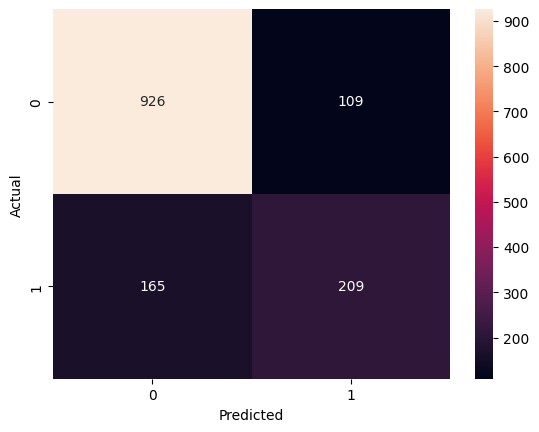

In [50]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**ROC Curve**

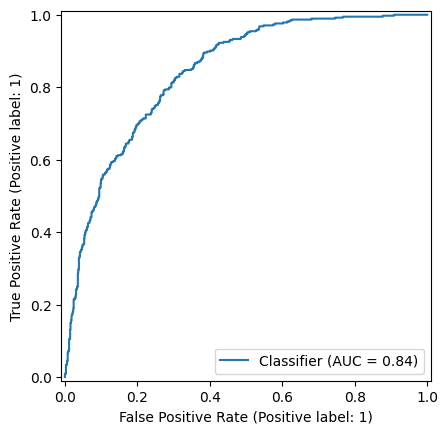

ROC-AUC Score: 0.8411506368028107


In [51]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


**STEP 9: Save Complete Pipeline (Production Ready)**

In [52]:
# Save entire pipeline (preprocessing + model)
joblib.dump(best_model.best_estimator_, "telco_churn_pipeline.pkl")

print("Model saved successfully!")


Model saved successfully!


**STEP 10: Load Model (For Deployment)**

In [53]:
model = joblib.load("telco_churn_pipeline.pkl")


**STEP 11: Gradio Demo**

**Prediction Function**

In [54]:
def predict_churn(
    gender, SeniorCitizen, Partner, Dependents, tenure,
    PhoneService, MultipleLines, InternetService, OnlineSecurity,
    OnlineBackup, DeviceProtection, TechSupport, StreamingTV,
    StreamingMovies, Contract, PaperlessBilling, PaymentMethod,
    MonthlyCharges, TotalCharges
):
    # Create DataFrame from inputs
    input_data = pd.DataFrame([{
        "gender": gender,
        "SeniorCitizen": int(SeniorCitizen),
        "Partner": Partner,
        "Dependents": Dependents,
        "tenure": tenure,
        "PhoneService": PhoneService,
        "MultipleLines": MultipleLines,
        "InternetService": InternetService,
        "OnlineSecurity": OnlineSecurity,
        "OnlineBackup": OnlineBackup,
        "DeviceProtection": DeviceProtection,
        "TechSupport": TechSupport,
        "StreamingTV": StreamingTV,
        "StreamingMovies": StreamingMovies,
        "Contract": Contract,
        "PaperlessBilling": PaperlessBilling,
        "PaymentMethod": PaymentMethod,
        "MonthlyCharges": MonthlyCharges,
        "TotalCharges": TotalCharges
    }])

    # Predict probability
    prob = model.predict_proba(input_data)[0][1]
    prediction = "Churn" if prob >= 0.5 else "No Churn"

    return f"Prediction: {prediction} | Churn Probability: {prob:.2f}"


**Gradio Interface**

In [56]:
import gradio as gr

interface = gr.Interface(
    fn=predict_churn,
    inputs=[
        gr.Dropdown(["Male", "Female"]),
        gr.Radio([0, 1], label="Senior Citizen"),
        gr.Dropdown(["Yes", "No"]),
        gr.Dropdown(["Yes", "No"]),
        gr.Number(label="Tenure"),
        gr.Dropdown(["Yes", "No"]),
        gr.Dropdown(["Yes", "No", "No phone service"]),
        gr.Dropdown(["DSL", "Fiber optic", "No"]),
        gr.Dropdown(["Yes", "No", "No internet service"]),
        gr.Dropdown(["Yes", "No", "No internet service"]),
        gr.Dropdown(["Yes", "No", "No internet service"]),
        gr.Dropdown(["Yes", "No", "No internet service"]),
        gr.Dropdown(["Yes", "No", "No internet service"]),
        gr.Dropdown(["Yes", "No", "No internet service"]),
        gr.Dropdown(["Month-to-month", "One year", "Two year"]),
        gr.Dropdown(["Yes", "No"]),
        gr.Dropdown([
            "Electronic check",
            "Mailed check",
            "Bank transfer (automatic)",
            "Credit card (automatic)"
        ]),
        gr.Number(label="Monthly Charges"),
        gr.Number(label="Total Charges")
    ],
    outputs="text",
    title="📊 Telco Customer Churn Prediction",
    description="End-to-End ML Pipeline using Scikit-learn"
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b5bf4d1f57980c19c0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
